In [1]:
# CUDA
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
print("CUDA?", torch.cuda.is_available())
x = torch.rand(10).cuda()

# NOTEBOOK
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
%matplotlib notebook

# IMPORTS
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from math import floor
import torchvision
import pickle
import time
import cupy as cp

from images import imread, pt2np, imwrite
from ResizeRight.resize_right import resize

from config import default_config as config
from utils import prob_hist, plot_hist, load_pickle, kl_divergence
from main import our_iqa_metric
from swd import weights_map_to_image
from pyramid import pyramid_scale_sqrt_2_shapes
from degrade import degrade

CUDA? True


ImportError: attempted relative import with no known parent package

In [5]:
from degrade import degrade

ImportError: attempted relative import with no known parent package

## dataset_huge  -->  dataset

In [ ]:
import torchvision
degradations = ["big_blur", "small_blur", "reference", "small_wn", "big_wn"]
for image_name in os.listdir(os.path.join(base_path, "dataset_huge")):
    image_path = os.path.join(base_path, "dataset_huge", image_name)
    original_image = imread(image_path)
    
    image_scales = pyramid_scale_sqrt_2_shapes(original_image, num_scales=9, patch_size=5, dim_max_size=1024)
    # resize to hr
    hr_image = resize(original_image, out_shape=image_scales[0]).clip(0, 1)
    
    for degradation in degradations:
        # degrade hr
        degraded = degrade(reference=hr_image, degradation=degradation).clip(0, 1)
    
        for scale_id, out_shape in enumerate(image_scales):
            curr_im = resize(degraded, out_shape=out_shape).clip(0, 1)
            imwrite(fname=os.path.join(base_path, "dataset_pyramid", f"image_{str(int(image_name[:-4]))}_degradation_{degradation}_scale_{scale_id}.png"), image=pt2np(curr_im))


## dataset  -->  pickles (use wandb...)

## pickles  -->  weight histograms

In [33]:
degradations = ["reference", "white_noise", "impulse_noise", "gauss_blur", "glass_blur", "jpeg"]
image_ids = [i for i in range(30)]
severities = [i for i in range(1, 8)]
plt.ioff()

# Load pickles


print("Loading pickles...")
kldivs_data = {degradation: torch.full((len(image_ids), len(severities), 2), torch.nan) for degradation in degradations if degradation != "reference"}
kldivs_data["reference"] = torch.full((len(image_ids), 2,), torch.nan)

for degradation in degradations:
    print(degradation)
    for image_id in image_ids:
        print(image_id, end=", ")
        if degradation == "reference":
            severity = None
            pickle_path = f"{config.base_path}/pickles/image_{image_id}_degradation_{degradation}_{severity}_noises_{config.num_noise}_proj_{config.num_proj}.pkl"
            pickle_result = load_pickle(path=pickle_path)
            _, _, histogram_pyramid = pickle_result
            kldivs = torch.tensor([kl_divergence(histogram_pyramid[0], histogram_pyramid[-1]),
                                   kl_divergence(histogram_pyramid[-1], histogram_pyramid[0])])
            kldivs_data[degradation][image_id] = kldivs
        else:
            for severity in severities:
                pickle_path = f"{config.base_path}/pickles/image_{image_id}_degradation_{degradation}_{severity}_noises_{config.num_noise}_proj_{config.num_proj}.pkl"
                pickle_result = load_pickle(path=pickle_path)
                _, _, histogram_pyramid = pickle_result
                kldivs = torch.tensor([kl_divergence(histogram_pyramid[0], histogram_pyramid[-1]),
                                       kl_divergence(histogram_pyramid[-1], histogram_pyramid[0])])
                kldivs_data[degradation][image_id][severity-1] = kldivs
    print()
print("Pickles loaded...")
print()


# Save graphs


print("Saving graphs...")
x = [i for i in range(8)]
for degradation in degradations:
    print(degradation)
    if degradation == "reference":
        continue

    # per-image graph
    for image_id in image_ids:
        print(image_id, end=", ")
        kldivs_0 = torch.cat([kldivs_data['reference'][image_id, 0].unsqueeze(0), kldivs_data[degradation][image_id, :, 0]])
        kldivs_1 = torch.cat([kldivs_data['reference'][image_id, 1].unsqueeze(0), kldivs_data[degradation][image_id, :, 1]])
        plt.plot(x, kldivs_0, c="blue")
        plt.plot(x, kldivs_1, c="red")
        plt.xlabel('severity')
        plt.ylabel('KL div')
        plt.title(f"{degradation} - Image {image_id}")
        out_path =  f"{config.base_path}/graphs_weights/{degradation}/image_{image_id}.png"
        os.makedirs(name=os.path.dirname(out_path), exist_ok=True)
        plt.savefig(fname=out_path, facecolor="white")
        plt.clf()
    
    # mean-over-images graph
    kldivs_0_mean = torch.cat([kldivs_data['reference'].mean(axis=0)[0].unsqueeze(0), kldivs_data[degradation].mean(axis=0)[:, 0]])
    kldivs_0_var = torch.cat([kldivs_data['reference'].var(axis=0)[0].unsqueeze(0), kldivs_data[degradation].var(axis=0)[:, 0]])
    kldivs_1_mean = torch.cat([kldivs_data['reference'].mean(axis=0)[1].unsqueeze(0), kldivs_data[degradation].mean(axis=0)[:, 1]])
    kldivs_1_var = torch.cat([kldivs_data['reference'].var(axis=0)[1].unsqueeze(0), kldivs_data[degradation].var(axis=0)[:, 1]])
    plt.errorbar(x=x, y=kldivs_0_mean, yerr=kldivs_0_var, c="blue")
    plt.errorbar(x=x, y=kldivs_1_mean, yerr=kldivs_1_var, c="red")
    plt.xlabel('severity')
    plt.ylabel('KL div')
    plt.title(f"{degradation} - all images")
    out_path =  f"{config.base_path}/graphs_weights/{degradation}/{degradation}_mean.png"
    os.makedirs(name=os.path.dirname(out_path), exist_ok=True)
    plt.savefig(fname=out_path, facecolor="white")
    plt.clf()
    print()
print("Graphs saved...")


Loading pickles...
reference
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
white_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
impulse_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
gauss_blur
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
glass_blur
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
jpeg
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
Pickles loaded...

Saving graphs...
reference
white_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
impulse_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,

<Figure size 432x288 with 0 Axes>

## pickles  -->  rgb histograms

In [34]:
def get_rgbm_kldivs(image_id, degradation, severity):
    if degradation == "reference":
        assert severity is None
    pickle_path = f"{config.base_path}/pickles/image_{image_id}_degradation_{degradation}_{severity}_noises_{config.num_noise}_proj_{config.num_proj}.pkl"
    pickle_result = load_pickle(path=pickle_path)
    image_pyramid = pickle_result[0]
    hr_image = image_pyramid[0]
    lr_image = image_pyramid[-1]
    # add grayscale
    hr_image_rgbm = torch.cat([hr_image, hr_image.mean(dim=1, keepdim=True)], dim=1)
    lr_image_rgbm = torch.cat([lr_image, lr_image.mean(dim=1, keepdim=True)], dim=1)
    # flatten values
    hr_image_rgbm_values = hr_image_rgbm.squeeze(0).flatten(start_dim=1)
    lr_image_rgbm_values = lr_image_rgbm.squeeze(0).flatten(start_dim=1)
    # histograms
    hr_image_rgbm_hist = torch.stack([torch.histc(hr_image_rgbm_values[i].cpu(), bins=256, min=0, max=1).cuda() for i in range(4)])
    hr_image_rgbm_hist = hr_image_rgbm_hist / hr_image_rgbm_hist.sum(dim=1, keepdim=True)
    lr_image_rgbm_hist = torch.stack([torch.histc(lr_image_rgbm_values[i].cpu(), bins=256, min=0, max=1).cuda() for i in range(4)])
    lr_image_rgbm_hist = lr_image_rgbm_hist / lr_image_rgbm_hist.sum(dim=1, keepdim=True)
    # kldivs
    kldivs = [[kl_divergence(hr_image_rgbm_hist[i], lr_image_rgbm_hist[i]) for i in range(4)], 
              [kl_divergence(lr_image_rgbm_hist[i], hr_image_rgbm_hist[i]) for i in range(4)]]
    return torch.tensor(kldivs)


degradations = ["reference", "white_noise", "impulse_noise", "gauss_blur", "glass_blur", "jpeg"]
image_ids = [i for i in range(30)]
severities = [i for i in range(1, 8)]
plt.ioff()


print("Computing kldivs...")
kldivs_data = {degradation: torch.full((len(image_ids), len(severities), 2, 4), torch.nan) for degradation in degradations if degradation != "reference"}
kldivs_data["reference"] = torch.full((len(image_ids), 2, 4), torch.nan)
for degradation in degradations:
    print(degradation)
    for image_id in image_ids:
        print(image_id, end=", ")
        if degradation == "reference":
            kldivs_data[degradation][image_id] = get_rgbm_kldivs(image_id, degradation, severity=None)
        else:
            for severity in severities:
                kldivs_data[degradation][image_id][severity-1] = get_rgbm_kldivs(image_id, degradation, severity)
    print()
print("Kldivs computed...")
print()


print("Saving graphs...")
x = [i for i in range(8)]
for degradation in degradations:
    print(degradation)
    if degradation == "reference":
        continue
    # per-image graph
    for image_id in image_ids:
        print(image_id, end=", ")
        kldivs = torch.cat([kldivs_data['reference'][image_id].unsqueeze(0), kldivs_data[degradation][image_id]])
        plt.plot(x, kldivs[:, 0, 0], c="red")
        plt.plot(x, kldivs[:, 0, 1], c="green")
        plt.plot(x, kldivs[:, 0, 2], c="blue")
        plt.plot(x, kldivs[:, 0, 3], c="gray")
        plt.plot(x, kldivs[:, 1, 0], c="darkred")
        plt.plot(x, kldivs[:, 1, 1], c="darkgreen")
        plt.plot(x, kldivs[:, 1, 2], c="darkblue")
        plt.plot(x, kldivs[:, 1, 3], c="black")
        plt.xlabel('severity')
        plt.ylabel('KL div')
        plt.title(f"{degradation} - Image {image_id}")
        out_path =  f"{config.base_path}/graphs_rgb/{degradation}/image_{image_id}.png"
        os.makedirs(name=os.path.dirname(out_path), exist_ok=True)
        plt.savefig(fname=out_path, facecolor="white")
        plt.clf()
    # mean-over-images graph
    kldivs_mean = torch.cat([kldivs_data['reference'].mean(axis=0).unsqueeze(0), kldivs_data[degradation].mean(axis=0)])
    kldivs_var = torch.cat([kldivs_data['reference'].var(axis=0).unsqueeze(0), kldivs_data[degradation].var(axis=0)])
    plt.errorbar(x=x, y=kldivs_mean[:, 0, 0], yerr=kldivs_var[:, 0, 0], c="red")
    plt.errorbar(x=x, y=kldivs_mean[:, 0, 1], yerr=kldivs_var[:, 0, 1], c="green")
    plt.errorbar(x=x, y=kldivs_mean[:, 0, 2], yerr=kldivs_var[:, 0, 2], c="blue")
    plt.errorbar(x=x, y=kldivs_mean[:, 0, 3], yerr=kldivs_var[:, 0, 3], c="gray")
    plt.errorbar(x=x, y=kldivs_mean[:, 1, 0], yerr=kldivs_var[:, 1, 0], c="darkred")
    plt.errorbar(x=x, y=kldivs_mean[:, 1, 1], yerr=kldivs_var[:, 1, 1], c="darkgreen")
    plt.errorbar(x=x, y=kldivs_mean[:, 1, 2], yerr=kldivs_var[:, 1, 2], c="darkblue")
    plt.errorbar(x=x, y=kldivs_mean[:, 1, 3], yerr=kldivs_var[:, 1, 3], c="black")
    plt.xlabel('severity')
    plt.ylabel('KL div')
    plt.title(f"{degradation} - all images")
    out_path =  f"{config.base_path}/graphs_rgb/{degradation}/{degradation}_mean.png"
    os.makedirs(name=os.path.dirname(out_path), exist_ok=True)
    plt.savefig(fname=out_path, facecolor="white")
    plt.clf()
    print()
print("Graphs saved...")


Computing kldivs...
reference
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
white_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
impulse_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
gauss_blur
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
glass_blur
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
jpeg
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
Kldivs computed...

Saving graphs...
reference
white_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
impulse_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1

<Figure size 432x288 with 0 Axes>

In [75]:
image_id = 0
degradation = "jpeg"
severity = 7

result_path = f"{config.base_path}/pickles/image_{image_id}_degradation_{degradation}_{severity}_noises_{config.num_noise}_proj_{config.num_proj}.pkl"
image_pyramid, weight_maps_pyramid, histogram_pyramid = load_pickle(result_path)

In [76]:
imwrite("/home/itaian/tmp/big.png", pt2np(image_pyramid[0]))
imwrite("/home/itaian/tmp/small.png", pt2np(image_pyramid[-1]))

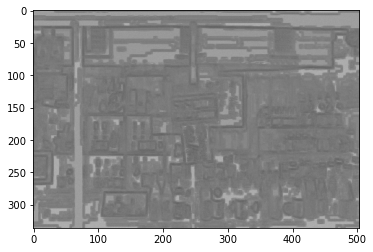

In [57]:
plt.imshow(pt2np(weights_map_to_image(weight_maps_pyramid[0], patch_size=config.patch_size)))

In [80]:
image = imread("/home/itaian/tmp/input.jpg")
jp = degrade(image, "jpeg", 5)
imwrite("/home/itaian/tmp/input_jp.png", pt2np(jp))

small_input = resize(image, scale_factors=0.01).clip(0, 1)
imwrite("/home/itaian/tmp/small_input.png", pt2np(small_input))
small_jp = resize(jp, scale_factors=0.01).clip(0, 1)
imwrite("/home/itaian/tmp/small_jp.png", pt2np(small_jp))

In [79]:
resize?


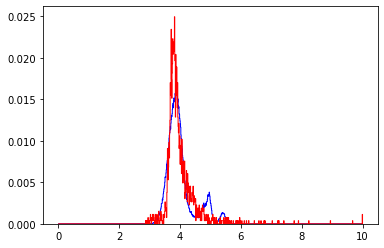

In [58]:
plot_hist(histogram_pyramid[0], start=0, end=10, color="blue")
plot_hist(histogram_pyramid[-1], start=0, end=10, color="red")

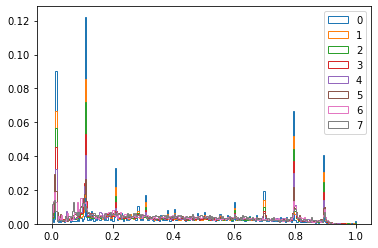

In [72]:
for i in range(8):
    plot_hist(prob_hist(image_pyramid[i].mean(dim=1).flatten(), bins=256, min=0, max=1), start=0, end=1, label=i)
plt.legend()


In [60]:
image_pyramid[2].mean(dim=1).flatten().shape

torch.Size([172720])

# Experiment

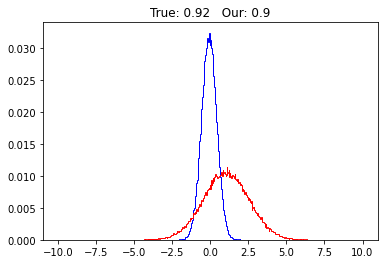

In [35]:
%matplotlib inline

def kld_gauss(u1, s1, u2, s2):
  # general KL two Gaussians
  # u2, s2 often N(0,1)
  # https://stats.stackexchange.com/questions/7440/ +
  # kl-divergence-between-two-univariate-gaussians
  # log(s2/s1) + [( s1^2 + (u1-u2)^2 ) / 2*s2^2] - 0.5
  v1 = s1 * s1
  v2 = s2 * s2
  a = np.log(s2/s1) 
  num = v1 + (u1 - u2)**2
  den = 2 * v2
  b = num / den
  return a + b - 0.5

u1, s1 = -0.1, 0.5
u2, s2 = 1, 1.5
numel = 100000
bins = 500
bounds = 10

# histograms
p = prob_hist(values=torch.normal(mean=u1+torch.zeros(numel), std=s1*torch.ones(numel)), 
              bins=bins, min=-bounds, max=bounds)
q = prob_hist(values=torch.normal(mean=u2+torch.zeros(numel), std=s2*torch.ones(numel)), 
              bins=bins, min=-bounds, max=bounds)

# KLs
kl = kl_divergence(p, q)
true = kld_gauss(u1, s1, u2, s2)

# plot
plot_hist(p, start=-bounds, end=bounds, color="blue")
plot_hist(q, start=-bounds, end=bounds, color="red")
plt.title(f"True: {round(true, 2)}   Our: {round(kl.item(), 2)}")
plt.show()


In [ ]:
def cupy_histogram(x, bins, device='cuda'):
    x = cp.asarray(x)
    bins = cp.asarray(bins)
    hist = cp.histogram(x=x, bins=bins)[0]
    return torch.as_tensor(hist, device=device)


for test in range(10):

    values = torch.rand(4 * 10000).cuda()
    bins = torch.rand(1000, 10000).sort(dim=1).values.cuda()

    # for loop
    start = time.time()
    hists = []
    for bin_idx in range(bins.size(0)):
        hists.append(cupy_histogram(x=values, bins=bins[bin_idx])) 
    hists = torch.stack(hists)
    end = time.time()
    loop = round(end - start, 2)

    # no loop
    start = time.time()
    hists2 = multi_bin_hist(values, bins)
    end = time.time()
    no_loop = round(end - start, 2)
    
    success_rate = round(100 * (hists == hists2).count_nonzero().item() / hists.numel(), 5)
    print(f"Test #{test} - {success_rate}%; loop took {loop}, no_loop took {no_loop}")


# OLD STUFF

## blur-reference-wn histograms 

In [ ]:
num_proj=256
num_noise=256
patch_size=5
base_path = f"/home/itaian/data/results/SWD/IQA"

degradations = ["big_blur", "small_blur", "reference", "small_wn", "big_wn"]
scales = [i for i in range(2, 9)]
colors = ["black", "purple", "blue", "green", "gold", "salmon", "red"]

for image_id in range(1, 19):
    print("Image", image_id)
    # image_id = 1

    fig, axs = plt.subplots(1, 5, figsize=(20, 12))
    fig.suptitle(f'image {image_id}')

    for ax_i, degradation in enumerate(degradations):

        ps = []
        for scale, color in zip(scales, colors):
            # get patch_counts
            base_name = f"image_{image_id}_degradation_{degradation}_scale_{scale}"
            weight_path = f"{base_path}/weights/{base_name}.pt"
            weights = torch.load(weight_path).cuda()
            patch_counts = weights.squeeze().mean(dim=0)[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2].flatten()
            patch_counts = patch_counts.sort().values.cpu().numpy()

            # plot hist
            z = axs[ax_i].hist(patch_counts, bins=1000, range=(2, 8), density=True, histtype="step", color=color, label=scale)
            axs[ax_i].legend()

            # for KL calc
            eps = 1e-4
            p = np.maximum(z[0] / z[0].sum(), eps)
            ps.append(p)

        kldiv = (kl_divergence(ps[0], ps[-1]) + kl_divergence(ps[-1], ps[0])) / 2
        axs[ax_i].set_title(f"{degradation}\nKL {round(kldiv, 4)}")
        
        image_path = f"{base_path}/histograms/image_{image_id}.png"
        os.makedirs(os.path.dirname(image_path), exist_ok=True)
        plt.savefig(fname=image_path, facecolor="white")


## condition numbers

In [ ]:
%matplotlib inline
from torchmetrics.functional import image_gradients
import torch.nn.functional as F
import matplotlib.pyplot as plt

for image_id in range(16, 17):
    print("Image", image_id)
    for degradation in degradations:
        for scale in scales:
            
            # read image
            base_name = f"image_{image_id}_degradation_{degradation}_scale_{scale}"
            image_path = f"{base_path}/dataset_pyramid/{base_name}.png"
            image = imread(image_path)
            h, w = image.shape[-2:]
            h_, w_ = h - (patch_size - 1), w - (patch_size - 1)

            # Lucas Kanade
            gray_image = image.mean(dim=1).unsqueeze(1)
            dy, dx = image_gradients(gray_image)
            dy = F.unfold(dy, kernel_size=patch_size).squeeze().t().reshape(h_, w_, patch_size, patch_size)
            dx = F.unfold(dx, kernel_size=patch_size).squeeze().t().reshape(h_, w_, patch_size, patch_size)
            LK = torch.stack([dx.pow(2).sum(dim=(2, 3)), 
                              (dx * dy).sum(dim=(2, 3)), 
                              (dx * dy).sum(dim=(2, 3)), 
                              dy.pow(2).sum(dim=(2, 3))], dim=2)
            LK = LK.reshape(h_, w_, 2, 2)

            # condition numbers
            eps = 1e-2
            singular_values = torch.linalg.svd(LK).S
            condition_numbers = singular_values[:, :, 0] / (singular_values[:, :, -1] + eps)
            condition_numbers = condition_numbers.view(1, 1, h_, w_)
            condition_numbers_plt = F.pad(condition_numbers, pad=[patch_size // 2] * 4, value=0)

            # plot condition number
            plt.imshow(condition_numbers_plt.squeeze().unsqueeze(-1).numpy())
            plt.colorbar()
            plt.title("Condition Numbers")
            plt.savefig(fname=f"{base_path}/LK_condition_numbers/{base_name}.png", facecolor="white")
            plt.close()


## interactive buttons

In [ ]:
@widgets.interact_manual(
    image_id=[i for i in range(1, 801)], 
    hr_scale=[2**i for i in range(0, 5)],
    degradation=["reference", "small_wn", "big_wn", "small_blur", "big_blur"], 
    num_proj=[2**i for i in range(6, 12)], 
    num_noise=[2**i for i in range(6, 12)])
def update(image_id=1, hr_scale=4, degradation="reference", num_proj=128, num_noise=512):

    # images
    hr_image = imread(os.path.join(config.DATASET_PATH, f'{image_id:04d}.png')).cuda()
    hr_image = resize(input=hr_image, scale_factors=1/hr_scale, pad_mode='reflect').clip(0, 1)
    hr_image = degrade(reference=hr_image, degradation=degradation).clip(0, 1)
    lr_image = resize(input=hr_image, scale_factors=0.5, pad_mode='reflect').clip(0, 1)
    image_path = f"/home/itaian/data/results/SWD/IQA/image_{image_id}_hr_scale_{hr_scale}_degradation_{degradation}_num_proj_{num_proj}_num_noise_{num_noise}"
    imwrite(fname=f"{image_path}_hr.png", image=pt2np(hr_image))
    imwrite(fname=f"{image_path}_lr.png", image=pt2np(lr_image))
    
    # projections
    proj_path = f"/home/itaian/data/projections/{num_proj}_{config.patch_size}.pt"
    if os.path.exists(proj_path):
        proj = torch.load(proj_path).cuda()
    else:
        proj = sample_random_projections(patch_size=config.patch_size, num_proj=num_proj)
        os.makedirs(os.path.dirname(proj_path), exist_ok=True)
        torch.save(proj, proj_path)

    # weight maps
    weight_path = f"/home/itaian/data/weights/image_{image_id}_hr_scale_{hr_scale}_degradation_{degradation}_num_proj_{num_proj}_num_noise_{num_noise}.pt"
    if os.path.exists(weight_path):
        weights = torch.load(weight_path).cuda()
        print("weights loaded")
    else:
        h, w = lr_image.shape[-2:]
        weights = torch.zeros(num_proj, 1, h, w)
        for _ in tqdm(range(num_noise)):
            weights += best_projection_weights(hr_image=add_noise(hr_image), lr_image=add_noise(lr_image), rand=proj).float().cpu()
        weights = weights / num_noise
        os.makedirs(os.path.dirname(weight_path), exist_ok=True)
        torch.save(weights, weight_path)
        imwrite(fname=weight_path[:-2]+".png", image=pt2np(weights.mean(dim=0, keepdims=True).repeat([1, 3, 1, 1]).clip(0, 8)/8))
        print("weights computed")

    # update state
    state.lr_image = pt2np(lr_image)
    state.weights = weights

def on_press(event):
    with open("/home/itaian/tmp/tmp/notebook.log", "ab") as f:
        # get pressed location
        h, w = floor(event.ydata), floor(event.xdata)

        patch_counts = sorted(state.weights.squeeze(dim=1)[:, h, w].tolist())
        mean = sum(patch_counts) / len(patch_counts)
        
        title = f'Mean: {round(mean, 3)}; Location: ({h}, {w})\n'
        f.write(title.encode())
        f.write(f'Counts: {patch_counts}\n'.encode())
        
        ax2.clear()
        ax2.hist(patch_counts, bins=[(i/3) for i in range(3*50)])
        ax2.set_title(title)
        fig.canvas.draw()
        
        f.write(f'\n'.encode())


# create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [7, 3]})
# connect figure to function
cid = fig.canvas.mpl_connect('button_press_event', on_press)
# plot image
ax1.imshow(state.lr_image)
